# Marginal Maximum Likelihood

You may have noticed that one of the necessary steps in using Gaussian Processes was to specify various hyperparameters: the kernel length scale and variance, and the observational error.  Sometimes we have a good idea what these things ought to be.  Most of the time we don't.  As such, we can also treat these values as free parameters to be learned from the data.  

However, it's not immediately clear what the cost function should be.  What do we need to minimize?  For making predictions with a GP, we compute
$$
P(Y^*|X^*,X,Y_{obs})
$$
or the distribution of a function $y(x)$ at test locations $X^*$, given some perhaps noisy observations of the same function at locations $X$.  The equation describing this is a normal distribution with mean
$$
\mu = K^* (K + \sigma^2 I)^{-1} Y_{obs}.
$$
Notice the $\sigma^2$ that appears.  Where does this come from?  Note that our covariance matrices only describe the relationship between the true function values at different points.  However, when we do regression, we don't get to see the true function value for the training data, but only some noisy version of it.  This means that the distribution of the training data is actually
$$
P(Y_{obs}|X) = \int P(Y_{obs}|Y) P(Y|X) dY
$$
where $P(Y|X)$ is a GP prior with covariance $K$, and $P(Y_{obs}|Y)$ is some model of noise, typically a normal distribution with diagonal covariance matrix $\sigma^2 I$.  It turns out that the expression above is tractable, which leads to another normal with covariance
$$
K + \sigma_{obs}^2 I,
$$
hence why this term enters the joint distribution when doing regression.  This also begs the question: how likely is the data under this prior to begin with?  In particular, we have observed values of $Y_{obs}$.  Is $P(Y_{obs}|X)$ big or small?  If it's large then our prior model over $P(Y)$ is probably a good one.  If it's small, our prior model is probably bad.  Taking things one step further, if we write $P(Y_{obs}|X,\ell,\sigma^2,\sigma_{obs}^2)$, we state explicitly that this likelihood over the data is dependent upon our hyperparameters: can we modify these hyperparameters so as to make the data as likely as possible?  It turns out that we can.  

To cast this as a minimization problem, we can take the negative log-likelihood up to a constant
$$
\mathcal{L}(\ell,\sigma^2,\sigma_{obs}^2) = \frac{1}{2} Y_{obs}^T (K(\ell,\sigma^2) + \sigma_{obs}^2 I)^{-1} Y_{obs} + \frac{1}{2} \ln \det [K(\ell,\sigma^2) + \sigma_{obs}^2 I  ]
$$
The first term measures the data misfit.  The second term penalizes model complexity (the closer the covariance gets to singular, the simpler the model tends to be with respect to the effective number of degrees of freedom). 

To minimize this thing, we need to take its gradient with respect to the parameters $\ell$, $\sigma^2$ and $\sigma^2_{obs}$.  This is a bit of an algebraic chore, especially since we have to differentiate through the kernel function.  However, we also know a means to make taking derivatives of complicated chains of functions very straightforward: automatic differentiation!  This makes the whole process quite easy to implement using pytorch.  

First, let's import some data.  This time it will be 2D, just for fun.



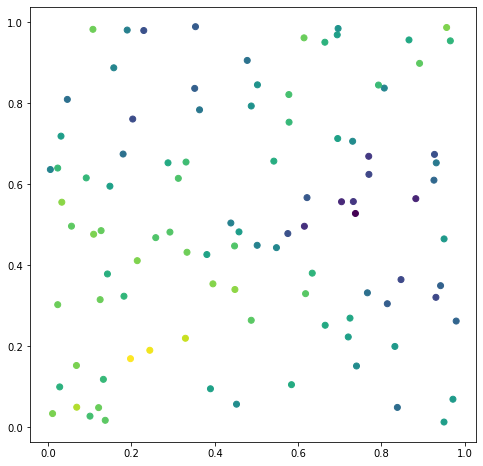

In [2]:
import torch
import matplotlib.pyplot as plt
X,Y = torch.load('training_data.pt')
plt.scatter(X[:,0],X[:,1],c=Y)
plt.gcf().set_size_inches(8,8)

Now, let's implement a squared-exponential kernel function in torch.

In [3]:
from scipy.spatial import distance_matrix #

def k(x,xp,l=0.3,sigma2=1.0):
    D = torch.from_numpy(distance_matrix(x,xp)).to(torch.float)
    return sigma2*torch.exp(-0.5*D**2/l**2)


Now we can implement the negative log-likelihood function.  Note that it's convenient to define a length three parameter vector (here called params) that holds our values of $\sigma^2_{obs}$, $\ell$, and $\sigma^2$, in that order.  Also, I'm doing a few tricks to make this faster and more numerically stable, in particular computing the cholesky decomposition $A = LL^T$, which then allows for straightfoward computation of both the log-determinant as well as the inverse-vector product (i.e. a linear solve).  

In [4]:
def marg_like(X,Y,params):
    sigma2_obs = params[0]
    l = params[1]
    sigma2 = params[2]
    K_emp = k(X,X,l=l,sigma2=sigma2)+sigma2_obs*torch.eye(X.shape[0])
    L = torch.linalg.cholesky(K_emp)
    K_logdet = 2*torch.log(torch.diag(L)).sum()
    marg_like = 0.5*Y @ torch.cholesky_solve(Y.reshape(-1,1),L).squeeze() + 0.5*K_logdet
    return marg_like 


With this function in hand, we can now minimize it using any optimization routine.  Here we'll use gradient descent.

In [5]:
eta = 1e-4  # Learning rate

# Initial guess for parameters.  Note the requires_grad flag
params = torch.tensor([1.0,0.9,0.25],requires_grad=True,dtype=torch.float)

# Run gradient descent
for i in range(2000):
    ml = marg_like(X,Y,params)  # Compute negative log likelihodd
    ml.backward()               # Backpropagate gradients
    
    # Update parameters
    params.data -= eta*params.grad.data
    
    # Clear gradient buffer
    params.grad.data[:] = 0.0
    
    if i%100==0:
        print("i: {0}, L: {1:.1f}, \sigma^2_obs: {2:.2f}, \ell: {3:.2f}, \sigma^2: {4:.2f}".format(*([i]+[ml.item()]+[i.item() for i in params])))

i: 0, L: 65.8, \sigma^2_obs: 1.00, \ell: 0.90, \sigma^2: 0.25
i: 100, L: 60.7, \sigma^2_obs: 1.04, \ell: 0.73, \sigma^2: 0.39
i: 200, L: 52.2, \sigma^2_obs: 1.01, \ell: 0.46, \sigma^2: 0.49
i: 300, L: 40.6, \sigma^2_obs: 0.86, \ell: 0.18, \sigma^2: 0.56
i: 400, L: 34.4, \sigma^2_obs: 0.62, \ell: 0.15, \sigma^2: 0.62
i: 500, L: 28.3, \sigma^2_obs: 0.39, \ell: 0.14, \sigma^2: 0.70
i: 600, L: 25.9, \sigma^2_obs: 0.27, \ell: 0.13, \sigma^2: 0.78
i: 700, L: 25.4, \sigma^2_obs: 0.25, \ell: 0.12, \sigma^2: 0.84
i: 800, L: 25.2, \sigma^2_obs: 0.24, \ell: 0.12, \sigma^2: 0.89
i: 900, L: 25.0, \sigma^2_obs: 0.24, \ell: 0.12, \sigma^2: 0.93
i: 1000, L: 24.9, \sigma^2_obs: 0.24, \ell: 0.12, \sigma^2: 0.96
i: 1100, L: 24.8, \sigma^2_obs: 0.24, \ell: 0.12, \sigma^2: 0.99
i: 1200, L: 24.8, \sigma^2_obs: 0.24, \ell: 0.12, \sigma^2: 1.01
i: 1300, L: 24.8, \sigma^2_obs: 0.24, \ell: 0.13, \sigma^2: 1.03
i: 1400, L: 24.7, \sigma^2_obs: 0.24, \ell: 0.13, \sigma^2: 1.05
i: 1500, L: 24.7, \sigma^2_obs: 0.24,

By the way, the true hyperparameters that were used to generate this dataset were $\sigma^2_{obs}=0.2$, $\ell=0.1$ and $\sigma^2=1$.  Now we can make some predictions based on these learned values using our standard formulae.

In [9]:
# Build the coordinates for evaluation
x1_test = torch.linspace(0,1,51)
x2_test = torch.linspace(0,1,51)
X1_test,X2_test = torch.meshgrid(x1_test,x2_test)
X_test = torch.vstack((X1_test.ravel(),X2_test.ravel())).T

# Create cross covariance matrix
K = k(X,X,l=params[1],sigma2=params[2]).detach()
K_star = k(X_test,X,l=params[1],sigma2=params[2]).detach()
K_starstar = k(X_test,X_test,l=params[1],sigma2=params[2]).detach()
K_inv = torch.linalg.inv(K + params[0]*torch.eye(K.shape[0])).detach()

# Compute posterior mean and covariance
mu_post = K_star @ K_inv @ Y
Sigma_post = K_starstar - K_star @ K_inv @ K_star.T

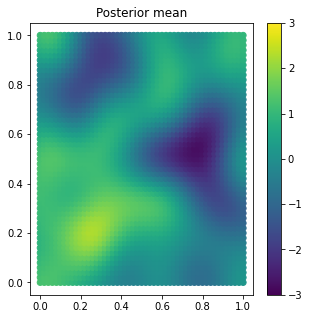

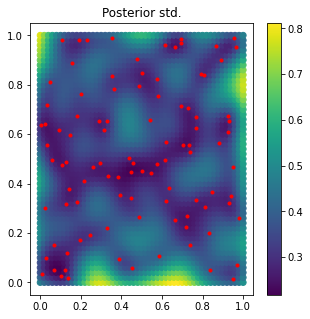

In [36]:
plt.figure()
plt.scatter(X_test[:,0],X_test[:,1],c=mu_post,vmin=-3,vmax=3)
plt.colorbar()
plt.title('Posterior mean')
plt.gcf().set_size_inches(5,5)
plt.figure()
plt.scatter(X_test[:,0],X_test[:,1],c=torch.sqrt(torch.diag(Sigma_post)))
plt.colorbar()
plt.plot(X[:,0],X[:,1],'r.')
plt.title('Posterior std.')
plt.gcf().set_size_inches(5,5)

As expected, the posterior standard deviation is smaller (but not zero) as one becomes close to an observation, and becomes larger as one gets further away.  We can easily draw random samples from this posterior as well

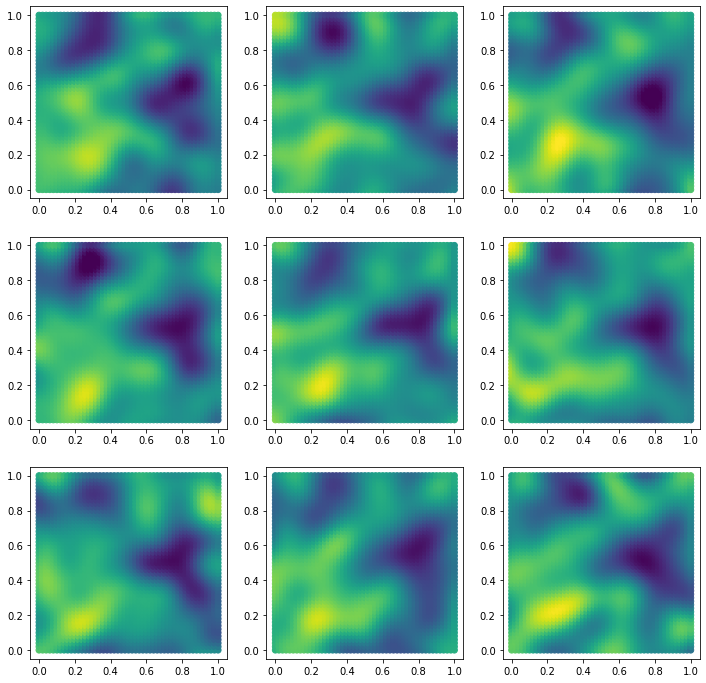

In [35]:
w,v = torch.linalg.eigh(Sigma_post)
w[w<0] = 0
samples = torch.randn(9,len(w)) @ torch.diag(torch.sqrt(w)) @ v.T

fig,axs = plt.subplots(nrows=3,ncols=3)
axs = axs.ravel()

for ax,s in zip(axs,samples):
    ax.scatter(X_test[:,0],X_test[:,1],c=mu_post + s,vmin=-3,vmax=3)
    plt.gcf().set_size_inches(12,12)
    